In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

import random

(800, 160, 160, 1) (800, 1)
(10, 160, 160, 1) (10, 1)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


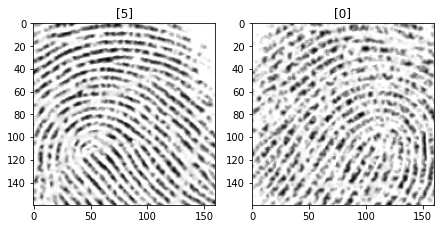

In [ ]:
# Load Train Data
img_train = np.load('/content/sample_data/img_train.npy')
label_train = np.load('/content/sample_data/label_train.npy')
img_test = np.load('/content/sample_data/img_test.npy')
label_test = np.load('/content/sample_data/label_test.npy')

print(img_train.shape, label_train.shape)
print(img_test.shape, label_test.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(label_test[5])
plt.imshow(img_test[5].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(label_train[0])
plt.imshow(img_train[0].squeeze(), cmap='gray')




In [ ]:
# data split
x_data = np.concatenate([img_train], axis=0)
label_data = np.concatenate([label_train], axis=0)

img_train, img_val, label_train, label_val = train_test_split(img_train, label_train, test_size=0.1)

print(img_test.shape, label_test.shape)
print(img_train.shape, label_train.shape)
print(img_val.shape, label_val.shape)



(10, 160, 160, 1) (10, 1)
(720, 160, 160, 1) (720, 1)
(80, 160, 160, 1) (80, 1)


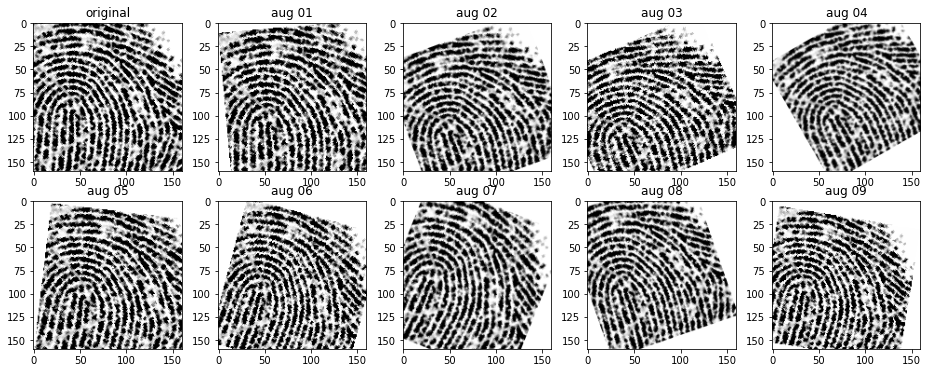

In [ ]:
# preview augmentation
augs = [img_train[580]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(img_train[580].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

In [ ]:
# label dictionary lookup
label_test_dict = {}

for i, y in enumerate(label_test):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_test_dict[key] = i

In [ ]:
# Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, label, img_test, label_test_dict, batch_size=64, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.img_test = img_test
        self.label_test_dict = label_test_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 160, 160, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.img_test[self.label_test_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_test_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.img_test[unmatch_idx]
                y_batch[i] = 0.
        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)       

        

In [ ]:
train_gen = DataGenerator(img_train, label_train, img_test, label_test_dict, shuffle=True)
val_gen = DataGenerator(img_val, label_val, img_test, label_test_dict, shuffle=False)

In [ ]:
# Defining Resnet Block, we define the simplest identity block where dimension of the input doesn’t change but only the depth
def res_identity(x, filters):

  ''' resnet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)


  return x


In [ ]:
# This residual block will include a change in the dimension of the input by using a 1×1 convolution with a stride 2
# Thus the skip connection will also go through a dimension change
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

 # create model
x1 = layers.Input(shape=(160, 160, 1))
x2 = layers.Input(shape=(160, 160, 1))

# share weights both inputs
inputs = layers.Input(shape=(160, 160, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



In [ ]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(img_train.shape[1], img_train.shape[2], img_train.shape[3])) 
  x = ZeroPadding2D(padding=(3, 3))(input_im)



  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

# 5th stage
  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(64, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model





In [ ]:
resnet50_model = resnet50()

In [ ]:
resnet50_model.summary()


Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 166, 166, 1)  0          ['input_16[0][0]']               
 D)                                                                                               
                                                                                                  
 conv2d_171 (Conv2D)            (None, 80, 80, 64)   3200        ['zero_padding2d_3[0][0]']       
                                                                                           

In [ ]:
#compilng resnet50 model
resnet50_model.compile(loss='binary_crossentropy', optimizer= "adam", 
                      metrics=['acc'])


In [ ]:
# Train
resnet_train = model.fit_generator(train_gen, epochs=100, validation_data=val_gen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
11/11 [==============================] - 34s 3s/step - loss: 0.4770 - acc: 0.7642 - val_loss: 0.4202 - val_acc: 0.8438
Epoch 2/100
11/11 [==============================] - 33s 3s/step - loss: 0.4732 - acc: 0.7741 - val_loss: 0.4856 - val_acc: 0.7344
Epoch 3/100
11/11 [==============================] - 33s 3s/step - loss: 0.4957 - acc: 0.7486 - val_loss: 0.3964 - val_acc: 0.8281
Epoch 4/100
11/11 [==============================] - 34s 3s/step - loss: 0.4635 - acc: 0.7614 - val_loss: 0.4099 - val_acc: 0.8750
Epoch 5/100
11/11 [==============================] - 33s 3s/step - loss: 0.4399 - acc: 0.7940 - val_loss: 0.4694 - val_acc: 0.7656
Epoch 6/100
11/11 [==============================] - 33s 3s/step - loss: 0.4665 - acc: 0.7670 - val_loss: 0.5282 - val_acc: 0.7031
Epoch 7/100
11/11 [==============================] - 33s 3s/step - loss: 0.4564 - acc: 0.7827 - val_loss: 0.3793 - val_acc: 0.8125
Epoch 8/100
11/11 [==============================] - 33s 3s/step - loss: 0.4333 - a

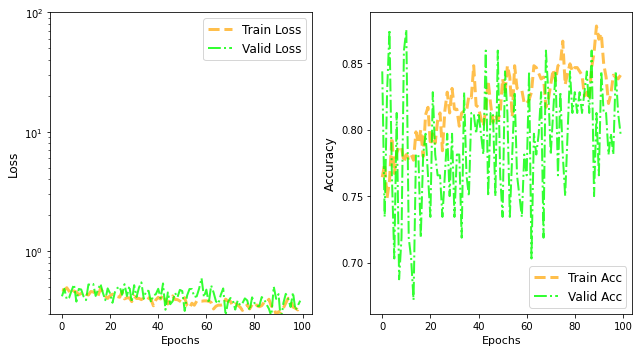

In [ ]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

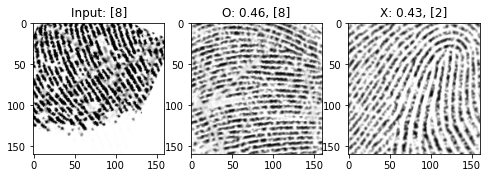

In [ ]:
# Evaluation
# new user fingerprint input
random_idx = random.randint(0, len(img_val))

random_img = img_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 160, 160, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = img_test[label_test_dict[match_key]].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
ry = label_test[label_test_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_test_dict.items()))

ux = img_test[unmatch_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
uy = label_test[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

In [ ]:
total_count = 0
error_count = 0
error_rage = 0.5
for input_idx in range(label_test.shape[0]):
    print('Processing #', input_idx, '')
    for db_idx in range(label_test.shape[0]):
        input_img = img_test[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        db_img = img_test[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        pred_right = model.predict([input_img, db_img])
        if (input_idx == db_idx):
            if (pred_right < error_rage):
                print('False Reject = ', pred_right)
                error_count += 1
        if (input_idx != db_idx):
            if (pred_right > error_rage):
                print('False Accept = ', pred_right, ', ID = ', db_idx)
                error_count += 1
        total_count += 1

# show result
print('Evaluation Finished')
print('Total Count = ', total_count)
print('Error Count = ', error_count)
print('Error Rate = ', (error_count / total_count) * 100)
print('Accuracy(%) = ', (100 - error_count))

Processing # 0 
False Accept =  [[0.50271606]] , ID =  1
False Accept =  [[0.50122225]] , ID =  5
False Accept =  [[0.51998043]] , ID =  8
Processing # 1 
False Accept =  [[0.5285422]] , ID =  3
False Accept =  [[0.55408376]] , ID =  4
False Accept =  [[0.55432445]] , ID =  5
False Accept =  [[0.5784414]] , ID =  6
False Accept =  [[0.5585176]] , ID =  7
Processing # 2 
False Accept =  [[0.5565111]] , ID =  1
False Accept =  [[0.5606649]] , ID =  3
False Accept =  [[0.54710335]] , ID =  4
False Accept =  [[0.5546834]] , ID =  5
False Accept =  [[0.5635646]] , ID =  6
False Accept =  [[0.54339963]] , ID =  7
Processing # 3 
False Accept =  [[0.5354286]] , ID =  1
False Accept =  [[0.55234146]] , ID =  4
False Accept =  [[0.5573411]] , ID =  5
False Accept =  [[0.585942]] , ID =  6
False Accept =  [[0.55131847]] , ID =  7
Processing # 4 
False Accept =  [[0.6019491]] , ID =  6
False Accept =  [[0.5527143]] , ID =  7
Processing # 5 
False Accept =  [[0.5242684]] , ID =  1
False Accept =  